## Libraries

In [1]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image


## Open Image

In [2]:
path="C:/Users/anama/OneDrive/Ambiente de Trabalho/UNI/Semestre2/ICSTS/Task3/ICSTS_EIT_Processment/set_01/trial_01/frame_004.png"

In [3]:

# Read image 
image = cv2.imread(path)


## RoI Selection

In [4]:
# Select ROI 
r = cv2.selectROI("select the area", image) # After selecting inted region press enter

In [ ]:
r #(220, 169, 194, 339)

(220, 169, 194, 339)

In [6]:
cv2.destroyWindow("select the area")

In [7]:
# Draw rectangle on the original image
x,y,w,h=r
image_with_roi = image.copy()
cv2.rectangle(image_with_roi, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red rectangle

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [9]:
# Show the ROI (optional)
cv2.imshow("Image with ROI", image_with_roi)
cv2.waitKey(0)
cv2.destroyWindow("Image with ROI")

## Apply RoI to all images

In [8]:
# Open all images from trial 1
image_files = sorted(glob('C:/Users/anama/OneDrive/Ambiente de Trabalho/UNI/Semestre2/ICSTS/Task3/ICSTS_EIT_Processment/set_01/trial_01/*.png'))  # Sort to preserve time order

In [9]:
len(image_files)

1361

In [10]:

# Set example image
image = Image.open(image_files[0])
image_np = np.array(image)
sample_image= image_np[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])] 

# Example shape from first image
sample_array = np.array(sample_image)
height, width, channels = sample_array.shape  # assuming RGB

# Preallocate image array (e.g., N images × H × W × C)
image_array = np.zeros((len(image_files), height, width, channels), dtype=np.uint8)


In [11]:
for image_num in range(len(image_files)):
    image = Image.open(image_files[image_num])
    image_np = np.array(image)
    image= image_np[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])] 

    image_array[image_num]=image

In [12]:
cv2.imshow("Image", image_array[40])
cv2.waitKey(0)
cv2.destroyWindow("Image")

## Get EIT Impedance waveform

In [13]:
impedance_variances = []

for image in image_array:
    
    # Convert to grayscale if needed, or to HSV to isolate intensity
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    intensity = hsv[:, :, 2]  # Value channel often correlates with impedance

    # Optional: mask out black background using threshold
    mask = intensity > 30  # tune threshold depending on your images
    valid_pixels = intensity[mask]

    # Compute variance of pixel values (impedance variance estimate)
    variance = np.var(valid_pixels)
    impedance_variances.append(variance)

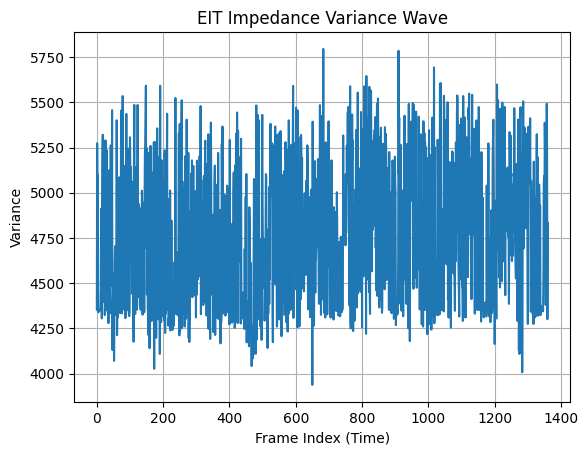

In [ ]:
plt.plot(impedance_variances)
plt.title("EIT Impedance Variance Wave")
plt.xlabel("Time (s)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

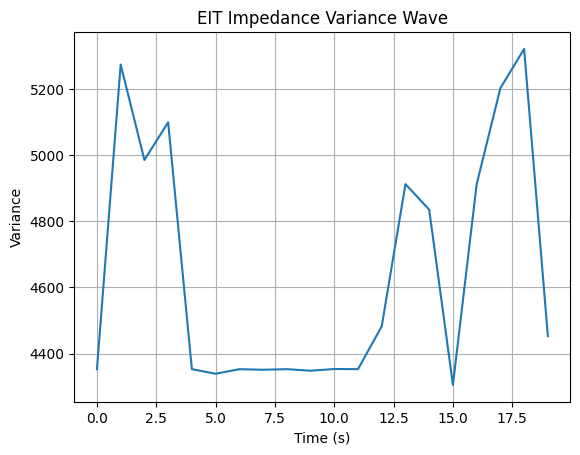

In [15]:
plt.plot(impedance_variances[0:20])
plt.title("EIT Impedance Variance Wave")
plt.xlabel("Time (s)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()